In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import random
from itertools import chain
def flatten(list_of_lists):
    "Flatten one level of nesting"
    return chain.from_iterable(list_of_lists)

In [3]:
def is_close_enough(pred, ratings):
    val = []
    for pair in zip(pred, ratings):
        if pair[1] == 5:
            val.append(pair[1] - 1 <= pair[0])
        else:
            val.append(pair[1] - .5 <= pair[0] <= pair[1] + .5)
        
    return val

In [4]:
# X_train = pd.read_pickle('saved_model/rmse_839/X_train.pkl')
# X_test = pd.read_pickle('saved_model/rmse_839/X_test.pkl')
ratings = pd.read_pickle("./Data/final_dataset_pre_split.pkl")

In [5]:
model = keras.models.load_model('saved_model/rmse_839/model.h5')

In [6]:
random_1000_users = random.choices(ratings.user.unique(), k=1000)

In [9]:
predictions = []
accuracy = []

for user in random_1000_users:
    movie_array = ratings[ratings.user==user].movie.values.astype(int)
    user_array = np.array([int(user) for n in range(len(movie_array))])
    pred = model.predict([movie_array, user_array])
    val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user==user].rating_score.values)
    
    predictions.append(list(pred.flatten()))
    accuracy.append(sum(val) / len(pred.flatten()))

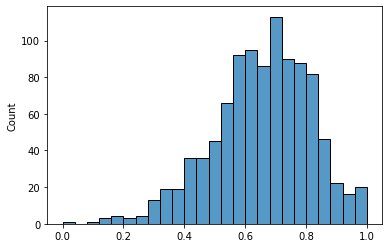

In [10]:
sns.histplot(accuracy)
plt.show()

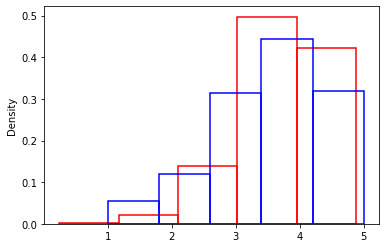

In [13]:
sns.histplot(list(flatten(predictions)), bins=5, color='red', fill=False,
            stat='density', common_norm=False)


sns.histplot(ratings[ratings.user.isin(random_1000_users)].rating_score.values, bins=5, color='blue', fill=False,
            stat='density', common_norm=False)

plt.show()

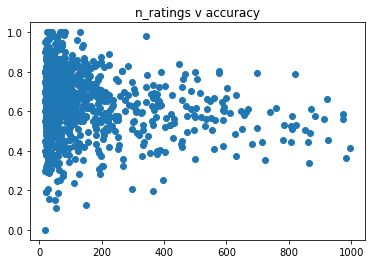

In [14]:
plt.scatter(x=ratings.groupby('user').count()['movie'].loc[random_1000_users].values,
           y=accuracy)

plt.title('n_ratings v accuracy')
plt.show()

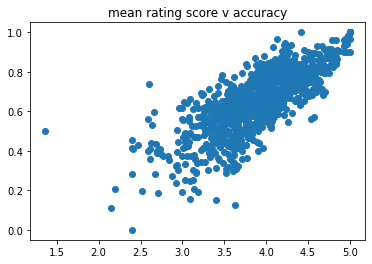

In [15]:
plt.scatter(x=ratings.groupby('user').mean()['rating_score'].loc[random_1000_users].values,
           y=accuracy)

plt.title('mean rating score v accuracy')
plt.show()

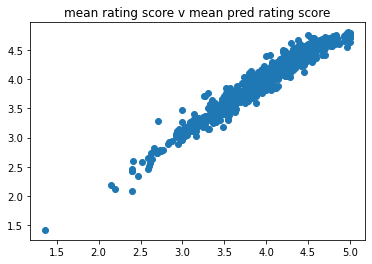

In [16]:
plt.scatter(x=ratings.groupby('user').mean()['rating_score'].loc[random_1000_users].values,
           y=[np.mean(pred) for pred in predictions])

plt.title('mean rating score v mean pred rating score')
plt.show()

Generate suggestions

In [18]:
user_accuracy = list(zip(random_1000_users, accuracy))

In [19]:
user_accuracy.sort(key=lambda x: x[1], reverse=True)

In [20]:
goods = random.choices([user_pair for user_pair in user_accuracy if (user_pair[1] < 1) and (user_pair[1] >= .8)], k=100)

In [22]:
def get_user_n_reviews(user):
    return len(ratings[ratings.user==user].movie)

In [24]:
n_reviews = []
for pairs in goods:
    nr = get_user_n_reviews(pairs[0])
    n_reviews.append(nr)

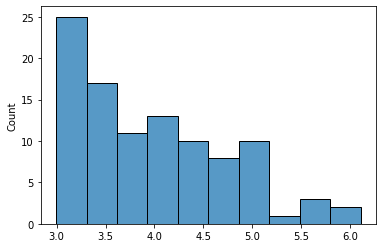

In [27]:
sns.histplot(np.log(n_reviews), bins=10)
plt.show()

In [17]:
unique_movies = ratings.movie.unique().astype(int)

In [33]:
suggestions = {}
for n, user in enumerate(random_1000_users): 
    user_array = np.ones(shape=len(unique_movies), dtype=int) * int(user)
    preds = model.predict([unique_movies, user_array])    
    suggestions[user] = preds
    del preds
    if n % 100 == 0:
        print("{} of 1000".format(n))
    

0 of 1000
100 of 1000
200 of 1000
300 of 1000
400 of 1000
500 of 1000
600 of 1000
700 of 1000
800 of 1000
900 of 1000


In [123]:
suggestions.keys()

dict_keys([7694, 63227, 29734, 32695, 36382, 22098, 42951, 37890, 13743, 23128, 36079, 47027, 49441, 43647, 24841, 37375, 62375, 45856, 35110, 46774, 25848, 5786, 12285, 45494, 57265, 59790, 27276, 55341, 30717, 54595, 51209, 27600, 45645, 14854, 62566, 52190, 32071, 52208, 54556, 17011, 60134, 57092, 2712, 43904, 36995, 13947, 53379, 57651, 37895, 60846, 63830, 59481, 33175, 14125, 53722, 46967, 7078, 56565, 4952, 33666, 54292, 62675, 45581, 17898, 36551, 19155, 55241, 436, 14440, 17814, 36745, 37380, 12021, 34421, 52141, 18572, 56464, 528, 11249, 57292, 32195, 42837, 48171, 2264, 58791, 48048, 55364, 22242, 52350, 6764, 6103, 30130, 52171, 1398, 23762, 2137, 44714, 45807, 52461, 56254, 58761, 24618, 23193, 25575, 33793, 37452, 21229, 113, 46449, 7065, 1737, 58415, 51603, 46815, 49733, 23392, 62504, 26801, 33324, 60022, 8554, 28591, 11524, 23444, 3184, 2267, 31577, 54093, 23118, 8251, 60698, 19986, 18241, 58684, 7181, 31924, 36056, 64813, 9116, 27263, 4902, 7471, 58235, 43442, 49719, 

In [128]:
new_suggestions = {}
for n, key in enumerate(suggestions.keys()):
    new_suggestions[key] = list(suggestions[key].flatten())

In [117]:
new_suggestions = {}
for n, key in enumerate(suggestions.keys()):
    new_key = str(key)
    new_suggestions[new_key] = list(suggestions[key].flatten())
    if n % 100 == 0:
        print("{} of 1000".format(n))
    

0 of 1000
100 of 1000
200 of 1000
300 of 1000
400 of 1000
500 of 1000
600 of 1000
700 of 1000
800 of 1000
900 of 1000


In [130]:
sug_df = pd.DataFrame.from_dict(new_suggestions)

In [132]:
sug_df = sug_df.T

In [133]:
sug_df.head()

,0,1,2,3,4,5,6,7,8,9,...,89408,89409,89410,89411,89412,89413,89414,89415,89416,89417
7694,3.371913,2.423481,2.655540,3.764639,3.912810,3.115484,3.663766,4.027112,4.406497,4.203984,...,3.831626,3.652729,3.541415,3.669677,3.310660,3.738312,3.225231,3.335327,3.311495,3.829377
63227,3.605288,2.655299,2.887406,3.998473,4.147266,3.348125,3.897531,4.256463,4.616818,4.436552,...,4.065382,3.886587,3.775316,3.903436,3.543799,3.972085,3.457992,3.568570,3.544270,4.063275
29734,3.312645,2.364397,2.596456,3.705198,3.853350,3.056259,3.604161,3.968632,4.365136,4.148092,...,3.772051,3.593004,3.482192,3.610110,3.251233,3.678781,3.165920,3.275906,3.252252,3.770262
32695,3.888916,2.936250,3.168440,4.278105,4.418001,3.630968,4.176013,4.518863,4.770262,4.652876,...,4.343443,4.170938,4.056883,4.187417,3.826812,4.254450,3.741595,3.851546,3.828119,4.340985
36382,2.349698,1.403203,1.635381,2.740026,2.886985,2.094969,2.639673,3.001391,3.405538,3.179348,...,2.806309,2.628923,2.518497,2.645710,2.289618,2.713877,2.203749,2.313923,2.289689,2.804653


In [137]:
sug_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 7694 to 1061
Columns: 89418 entries, 0 to 89417
dtypes: float64(89418)
memory usage: 674.7 MB


In [138]:
rounded = sug_df.apply(lambda x: np.round(x, 2))

In [139]:
rounded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 7694 to 1061
Columns: 89418 entries, 0 to 89417
dtypes: float64(89418)
memory usage: 674.7 MB


In [141]:
rounded = rounded.astype('float32')

In [142]:
rounded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 7694 to 1061
Columns: 89418 entries, 0 to 89417
dtypes: float32(89418)
memory usage: 337.4 MB


In [143]:
pd.to_pickle(rounded, "jsons/1k_user_suggestions.pkl")

In [144]:
ratings.head()

,movie_id,rating_score,user_id,user,movie
0,1066,3,41579158,27189,1022
4,1066,4,68654088,44721,1022
5,1066,4,97262846,62992,1022
7,1066,3,57756708,37698,1022
8,1066,4,58420503,38127,1022


In [152]:
actual_ratings = ratings[ratings.user.isin(rounded.index)][['user', 'movie', 'rating_score']].reset_index(drop=True)

In [155]:
actual_ratings = actual_ratings.astype('int32')

In [156]:
actual_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137587 entries, 0 to 137586
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   user          137587 non-null  int32
 1   movie         137587 non-null  int32
 2   rating_score  137587 non-null  int32
dtypes: int32(3)
memory usage: 1.6 MB


In [157]:
actual_ratings['rating_score'] = actual_ratings['rating_score'].astype('int8')

In [158]:
actual_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137587 entries, 0 to 137586
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   user          137587 non-null  int32
 1   movie         137587 non-null  int32
 2   rating_score  137587 non-null  int8 
dtypes: int32(2), int8(1)
memory usage: 1.2 MB


In [161]:
pd.to_pickle(actual_ratings, "jsons/1k_user_ratings.pkl")

In [105]:
def get_recs(user):
    has_seen = [np.where(unique_movies==r)[0][0] for r in ratings[ratings.user==user].movie]
    
    movies_to_eval = random.choices(range(len(unique_movies)), k=100)
    movies_to_eval = [m for m in movies_to_eval if m not in list(has_seen)]

    if len(movies_to_eval) != 100:
        still_need = 100 - len(movies_to_eval)
        extras = random.choices(range(len(unique_movies)), k=still_need)
        for e in extras:
            if (e not in movies_to_eval) and (e not in has_seen):
                movies_to_eval.append(e)
            else:
                continue
                
    rates = suggestions[user].flatten()[movies_to_eval]
    movie_indx = unique_movies[movies_to_eval]
    movies = (movie_to_title(m) for m in movie_indx)
    movies_ratings = list(zip(movies, rates))
    movies_ratings.sort(key=lambda x: x[1], reverse=True)
    
    return movies_ratings[:5]

In [107]:
get_recs(10110)

[("The Schoolteacher Goes to Boys' High", 4.882003),
 ('Apocalypse Child', 4.875217),
 ('Handsworth Songs', 4.871039),
 ('Success Is the Best Revenge', 4.8680015),
 ('The Madness of Max', 4.866543)]

In [38]:
def get_user_model_performance(user):
    has_seen = [np.where(unique_movies==r)[0][0] for r in ratings[ratings.user==user].movie]
    
    user_pred = suggestions[user].flatten()[has_seen]
    user_ratings = ratings[(ratings.user==user)&ratings.movie.isin(unique_movies[has_seen])].rating_score.values
    vals = is_close_enough(user_pred, user_ratings)
    
    return sum(vals) / len(user_pred)

In [39]:
get_user_model_performance(7694)

0.6311475409836066

In [40]:
get_user_n_reviews(7694)

366

In [45]:
def get_user_mean(user):
    return ratings[ratings.user==user].rating_score.mean()

In [46]:
get_user_mean(7694)

3.8825136612021858

In [48]:
import json
with open("jsons/movie_titles.json", 'r') as f:
    id_to_title = json.load(f)
    
with open("jsons/movie_to_id.json", 'r') as f:
    movie_to_id = json.load(f)

In [49]:
id_to_title

{'1': 'La Antena',
 '2': 'Elementary Particles',
 '3': "It's Winter",
 '4': 'Kirikou and the Wild Beasts',
 '5': 'Padre Nuestro',
 '6': 'The Perfume of the Lady in Black',
 '7': 'Riviera',
 '8': "Someone Else's Happiness",
 '9': 'Young Yakuza',
 '10': 'The Return',
 '11': 'Il grido',
 '12': 'The General',
 '13': "L'Age d'Or",
 '14': 'Les bonnes femmes',
 '15': 'Cops',
 '16': 'Tokyo Eyes',
 '17': 'Dead in 3 Days',
 '18': 'The Wind of the Night',
 '20': 'Chicken Heart',
 '21': 'After Life',
 '22': '17 rue Bleue',
 '23': 'Agua',
 '24': "Don't Forget You're Going to Die",
 '25': 'Foreign Land',
 '26': 'Kids Return',
 '27': 'Midnight',
 '28': 'Journey to the Sun',
 '29': 'Pickpocket',
 '30': 'La promesse',
 '31': 'U the Unicorn',
 '32': 'The Take',
 '33': 'Princes and Princesses',
 '35': 'Bashing',
 '36': 'Bird Now',
 '38': 'Gabriel Orozco',
 '39': 'I Love Beijing',
 '40': 'La sentinelle',
 '41': 'Light of My Eyes',
 '42': 'Little Terrorist',
 '43': 'Long Life, Happiness and Prosperity',
 '

In [50]:
movie_to_id

{'1022': 1066,
 '1023': 1067,
 '1024': 1068,
 '1025': 1069,
 '1026': 1070,
 '1027': 1071,
 '1028': 1072,
 '1029': 1073,
 '1030': 1076,
 '1031': 1077,
 '1032': 1078,
 '1033': 1079,
 '1034': 1080,
 '1035': 1082,
 '1036': 1083,
 '1037': 1084,
 '1038': 1085,
 '1039': 1086,
 '1040': 1087,
 '1041': 1088,
 '1042': 1089,
 '1043': 1090,
 '1044': 1091,
 '1045': 1092,
 '1046': 1093,
 '1047': 1094,
 '1048': 1095,
 '1049': 1096,
 '1050': 1097,
 '1051': 1098,
 '1052': 1099,
 '1053': 1100,
 '1054': 1101,
 '1055': 1102,
 '1056': 1103,
 '1057': 1104,
 '1058': 1105,
 '1059': 1106,
 '1060': 1107,
 '1061': 1108,
 '1062': 1109,
 '1063': 1110,
 '1064': 1111,
 '1065': 1112,
 '1066': 1113,
 '1067': 1114,
 '1068': 1115,
 '1069': 1116,
 '1070': 1117,
 '1071': 1118,
 '1072': 1119,
 '1073': 1120,
 '1074': 1121,
 '1075': 1122,
 '1076': 1123,
 '1077': 1124,
 '1078': 1125,
 '1079': 1126,
 '1080': 1127,
 '1081': 1129,
 '1082': 1130,
 '1083': 1131,
 '1084': 1132,
 '1085': 1133,
 '1086': 1134,
 '1087': 1135,
 '1088': 1

In [75]:
def movie_to_title(movie_number):
    movie_id = movie_to_id[str(movie_number)]
    title = id_to_title[str(movie_id)]
    return title

In [80]:
movie_to_title(24442)

'Yesterday'

In [81]:
def get_user_top_n_movies(user, n=10):
    ranks = ratings[ratings.user==user].sort_values(by='rating_score', ascending=False)
    
    movies = ranks.movie.values[:n]
    rates = ranks.rating_score.values[:n]
    titles = (movie_to_title(m) for m in movies)

    return list(zip(titles, rates))

In [82]:
get_user_top_n_movies(10110)

[('Evil Dead II', 5),
 ("Killer's Kiss", 5),
 ('Alien', 5),
 ('Barry Lyndon', 5),
 ('Spartacus', 5),
 ('Paths of Glory', 5),
 ('The Killing', 5),
 ('The Shining', 5),
 ('Eyes Wide Shut', 5),
 ('Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb', 5)]